# Generative Adversarial Networks (GANs) for Data Augmentation

## Abstract

This notebook explores Generative Adversarial Networks (GANs) and their application in data augmentation. Readers will learn about the fundamental architecture of GANs, including the generator and discriminator components, their adversarial training process, and how GANs can generate synthetic data to augment limited datasets. The notebook provides a thorough examination of GAN architecture variants, training methodologies, and common challenges like mode collapse. Through hands-on code examples with the MNIST dataset, we demonstrate how GANs can generate realistic synthetic images and how conditional GANs can generate class-specific samples. These techniques prove particularly valuable in scenarios with limited training data or class imbalance issues, showcasing GANs' significant potential for enhancing model performance across various domains.

## 1. Introduction to Generative Adversarial Networks

### 1.1 What are GANs?

Generative Adversarial Networks (GANs) represent a revolutionary approach to generative modeling introduced by Ian Goodfellow and colleagues in 2014. Unlike traditional generative models, GANs employ an adversarial process where two neural networks compete against each other:

- **Generator (G)**: Creates synthetic data samples from random noise
- **Discriminator (D)**: Evaluates whether a sample is real (from the training dataset) or fake (created by the generator)

The generator aims to produce data that is indistinguishable from real data, while the discriminator tries to correctly identify which data is real and which is synthetic. Through this adversarial process, both networks improve over time, with the generator eventually creating highly realistic synthetic data.

![GAN Architecture Diagram](https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg)

### 1.2 Types of Generative Models

GANs are part of a broader family of generative models, each with unique approaches and strengths:

1. **Generative Adversarial Networks (GANs)**:
   - Use adversarial training between generator and discriminator
   - Excel at generating high-quality, realistic images
   - Variants include DCGANs, StyleGANs, and Conditional GANs

2. **Variational Autoencoders (VAEs)**:
   - Combine autoencoder architecture with variational inference
   - Learn a probabilistic latent space representation
   - Often produce smoother but sometimes blurrier results than GANs

3. **Diffusion Models**:
   - Gradually add noise to data and learn to reverse the process
   - Recent advancements (DALL-E 2, Stable Diffusion) show impressive results
   - Often more stable to train than GANs

4. **Transformer-based Models**:
   - Use attention mechanisms for sequence generation
   - Power text generation models like GPT
   - Can be adapted for image generation (e.g., ViT)

For this notebook, we'll focus specifically on GANs and their application to data augmentation.

### 1.3. The GAN Architecture

The basic architecture of a GAN consists of two main components:

1. **Generator Network**: Takes random noise as input and transforms it into synthetic data. In the case of image generation, the generator maps from a low-dimensional latent space to a high-dimensional image space.

2. **Discriminator Network**: Takes either real or generated data as input and outputs a probability indicating whether the input is real or fake. The discriminator essentially performs binary classification.

Let's set up our environment and import the necessary libraries:

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import time
from IPython import display
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check for GPU availability
print("TensorFlow version:", tf.__version__)
print("GPU Available: ", len(tf.config.list_physical_devices('GPU')) > 0)



TensorFlow version: 2.19.0
GPU Available:  False


### 1.4 GAN Training Dynamics

The training process of GANs involves a minimax game between the generator and discriminator:

$$\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

Where:
- $G$ represents the generator
- $D$ represents the discriminator
- $p_{data}$ is the distribution of real data
- $p_z$ is a prior distribution on input noise (typically Gaussian)

In practice, training a GAN involves:
1. Training the discriminator on both real and fake data
2. Training the generator to fool the discriminator
3. Alternating between steps 1 and 2 until convergence

Let's visualize the GAN training process to understand how distributions evolve:

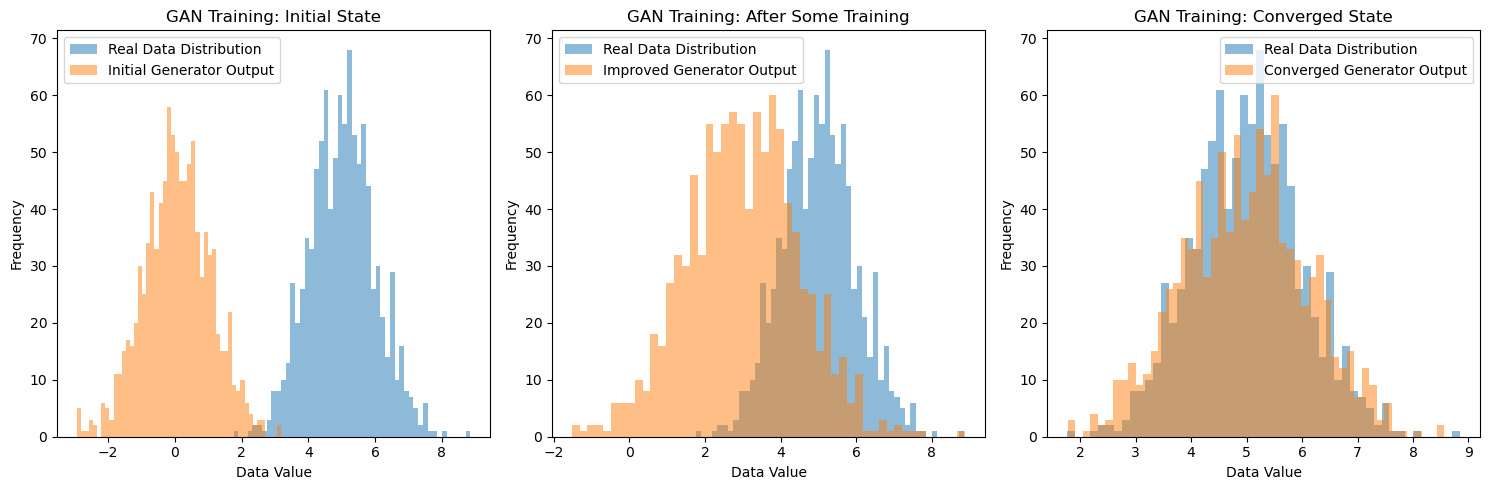

In [3]:
# Visualizing the GAN training process
plt.figure(figsize=(15, 5))

# Initial state: Generator output is far from real data
x = np.linspace(-10, 10, 1000)
real_data = np.random.normal(5, 1, 1000)
initial_fake = np.random.normal(0, 1, 1000)

plt.subplot(1, 3, 1)
plt.hist(real_data, bins=50, alpha=0.5, label='Real Data Distribution')
plt.hist(initial_fake, bins=50, alpha=0.5, label='Initial Generator Output')
plt.title('GAN Training: Initial State')
plt.legend()
plt.xlabel('Data Value')
plt.ylabel('Frequency')

# Middle state: Generator is improving
improved_fake = np.random.normal(3, 1.5, 1000)
plt.subplot(1, 3, 2)
plt.hist(real_data, bins=50, alpha=0.5, label='Real Data Distribution')
plt.hist(improved_fake, bins=50, alpha=0.5, label='Improved Generator Output')
plt.title('GAN Training: After Some Training')
plt.legend()
plt.xlabel('Data Value')
plt.ylabel('Frequency')

# Converged state: Generator closely matches real data
good_fake = np.random.normal(5, 1.1, 1000)
plt.subplot(1, 3, 3)
plt.hist(real_data, bins=50, alpha=0.5, label='Real Data Distribution')
plt.hist(good_fake, bins=50, alpha=0.5, label='Converged Generator Output')
plt.title('GAN Training: Converged State')
plt.legend()
plt.xlabel('Data Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 2. GAN Architectures for Image Generation

### 2.1 Deep Convolutional GAN (DCGAN)

Deep Convolutional GANs (DCGANs) were introduced to leverage the power of convolutional neural networks for image generation. They incorporate several architectural guidelines:

- Replace pooling layers with strided convolutions (discriminator) and transposed convolutions (generator)
- Use BatchNormalization in both networks
- Remove fully connected hidden layers
- Use ReLU activation in the generator (except for the output layer)
- Use LeakyReLU activation in the discriminator

Let's implement a DCGAN for generating MNIST digits:

In [5]:
# Function to create a simple GAN model visualization
def build_simple_gan_model():
    # Generator
    noise_dim = 100
    generator = models.Sequential([
        layers.Dense(7*7*256, input_dim=noise_dim),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ], name='generator')
    
    # Discriminator
    discriminator = models.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(256),
        layers.LeakyReLU(alpha=0.2),
        layers.Dense(1, activation='sigmoid')
    ], name='discriminator')
    
    return generator, discriminator

# Create models
generator, discriminator = build_simple_gan_model()

# Display model summaries
print("Generator Architecture:")
generator.summary()

print("\nDiscriminator Architecture:")
discriminator.summary()

Generator Architecture:


C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,266,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,293,505 (8.75 MB)

 Trainable params: 2,293,121 (8.75 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator Architecture:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,813,249 (6.92 MB)

 Trainable params: 1,812,993 (6.92 MB)

 Non-trainable params: 256 (1.00 KB)

### 2.2 Conditional GAN (CGAN)

Conditional GANs allow us to control the generation process by conditioning both the generator and discriminator on additional information, such as class labels. This enables generating samples from specific classes, which is particularly useful for data augmentation.

In [7]:
def build_conditional_gan(latent_dim=100, num_classes=10):
    # Generator
    noise_input = tf.keras.Input(shape=(latent_dim,))
    label_input = tf.keras.Input(shape=(1,))
    
    # Embedding for categorical input
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Combine noise and label
    combined_input = layers.Concatenate()([noise_input, label_embedding])
    
    # Dense layers
    x = layers.Dense(7 * 7 * 256)(combined_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Reshape
    x = layers.Reshape((7, 7, 256))(x)
    
    # Transposed convolution layers
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Output layer
    generator_output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')(x)
    generator = models.Model([noise_input, label_input], generator_output, name='Conditional_Generator')
    
    # Discriminator
    image_input = tf.keras.Input(shape=(28, 28, 1))
    label_input_disc = tf.keras.Input(shape=(1,))
    
    # Process image
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Process label
    label_embedding_disc = layers.Embedding(num_classes, 50)(label_input_disc)
    label_embedding_disc = layers.Flatten()(label_embedding_disc)
    label_embedding_disc = layers.Dense(14 * 14)(label_embedding_disc)
    label_embedding_disc = layers.Reshape((14, 14, 1))(label_embedding_disc)
    
    # Concatenate image features with label
    x = layers.Concatenate()([x, label_embedding_disc])
    
    # More convolution layers
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Output layer
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)
    discriminator = models.Model([image_input, label_input_disc], discriminator_output, name='Conditional_Discriminator')
    
    return generator, discriminator

# Create Conditional GAN models
cond_generator, cond_discriminator = build_conditional_gan()

print("Conditional Generator Architecture:")
cond_generator.summary()

print("\nConditional Discriminator Architecture:")
cond_discriminator.summary()

Conditional Generator Architecture:


Model: "Conditional_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 150)       │          0 │ input_layer_2[0]… │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12544)     │  1,894,144 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12544)     │     50,176 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 256) │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 7, 7, 128) │    819,328 │ reshape_1[0][0]   │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 14, 14,    │    204,864 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 28, 28, 1) │      1,601 │ leaky_re_lu_7[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,971,381 (11.33 MB)

 Trainable params: 2,945,909 (11.24 MB)

 Non-trainable params: 25,472 (99.50 KB)


Conditional Discriminator Architecture:


Model: "Conditional_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │      1,664 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 196)       │      9,996 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 14, 14, 1) │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 14, 14,    │          0 │ leaky_re_lu_8[0]… │
│ (Concatenate)       │ 65)               │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 128) │    208,128 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 6272)      │          0 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │  1,605,888 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_10      │ (None, 256)       │          0 │ dense_5[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        257 │ leaky_re_lu_10[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,826,945 (6.97 MB)

 Trainable params: 1,826,689 (6.97 MB)

 Non-trainable params: 256 (1.00 KB)

## 3. Training GANs

### 3.1 Training Challenges

Training GANs can be notoriously difficult due to several challenges:

1. **Mode Collapse**: When the generator produces a limited variety of samples

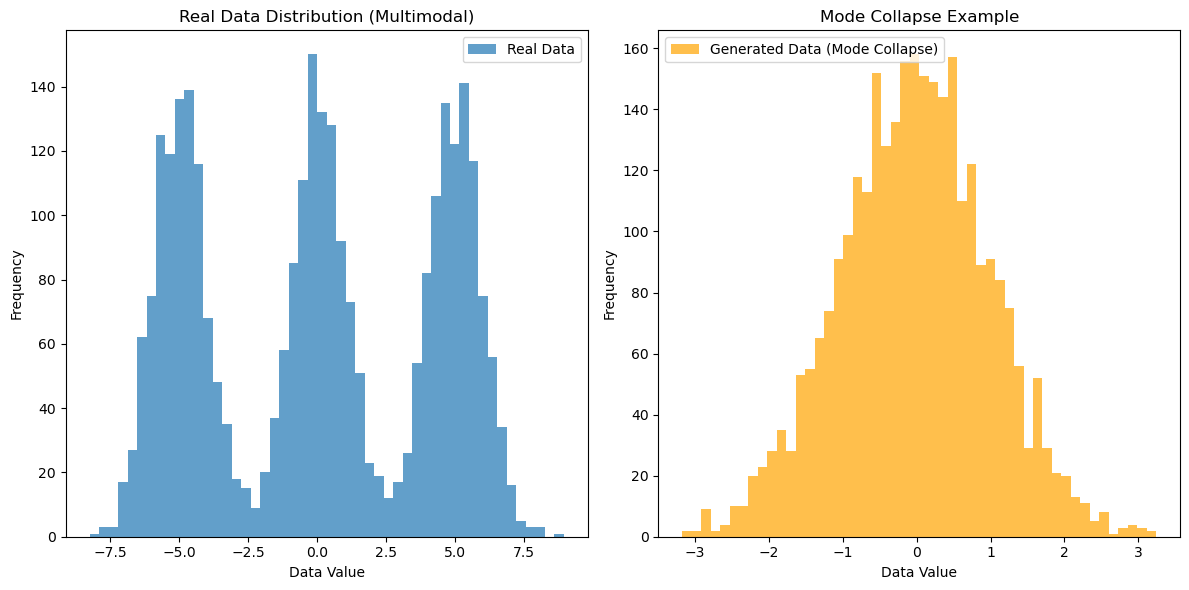

In [9]:
# Visualizing mode collapse
plt.figure(figsize=(12, 6))

# Generate some sample data
np.random.seed(42)
real_modes = np.concatenate([
    np.random.normal(-5, 1, 1000),
    np.random.normal(0, 1, 1000),
    np.random.normal(5, 1, 1000)
])

# Simulated mode collapse (generator only captures one mode)
mode_collapsed = np.random.normal(0, 1, 3000)

plt.subplot(1, 2, 1)
plt.hist(real_modes, bins=50, alpha=0.7, label='Real Data')
plt.title('Real Data Distribution (Multimodal)')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mode_collapsed, bins=50, alpha=0.7, color='orange', label='Generated Data (Mode Collapse)')
plt.title('Mode Collapse Example')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

2. **Training Instability**: When training oscillates rather than converges
3. **Vanishing Gradients**: When the discriminator becomes too good, it stops providing useful gradients to the generator
4. **Balance Problems**: When one network overpowers the other

To address these challenges, researchers have developed several techniques:
- Wasserstein GAN (WGAN): Uses Wasserstein distance instead of Jensen-Shannon divergence
- Spectral Normalization: Stabilizes discriminator training
- Progressive Growing: Gradually increases image resolution during training
- Two Time-Scale Update Rule (TTUR): Uses different learning rates for generator and discriminator

### 3.2 GAN Training Implementation

Now let's implement the training loop for our DCGAN:

## 1. Imports and Setup

Essential libraries are imported:
- `numpy` and `matplotlib` for data manipulation and visualization.
- `tensorflow` for building and training the DCGAN model.
- `os` and `time` for directory handling and tracking training time.

## 2. Random Seed and Output Directory

Random seeds are set for both NumPy and TensorFlow to ensure reproducibility. A directory named `gan_outputs` is created if it doesn't already exist. This folder will store the output images and plots generated during training.

## 3. Loading and Preprocessing Data

The MNIST dataset is loaded using TensorFlow's built-in API. Training images are normalized to the range [-1, 1] to aid GAN stability and performance. Additionally, a channel dimension is added to match the expected input shape of convolutional layers.

## 4. Generator Model

The generator model takes a 100-dimensional noise vector as input and produces a 28x28x1 fake image:
- A dense layer projects the noise vector into a 7x7x128 feature map.
- Two transposed convolution layers (also called deconvolution or upsampling layers) progressively upscale the feature map.
- Batch normalization and LeakyReLU activations are used after each layer (except the output layer).
- The output layer uses a `tanh` activation to match the input normalization of [-1, 1].

## 5. Discriminator Model

The discriminator model takes a 28x28x1 image and outputs a probability indicating whether the image is real or generated:
- Two convolutional layers reduce the spatial dimensions of the image.
- Each convolutional block includes a LeakyReLU activation and Dropout to prevent overfitting.
- The final output is a single neuron with a sigmoid activation.

## 6. Compiling Models

The generator and discriminator are instantiated using the `build_generator()` and `build_discriminator()` functions. Their architecture summaries are printed for inspection.

## 7. Loss Functions and Optimizers

Binary cross-entropy loss is used for both generator and discriminator. The generator aims to fool the discriminator (outputs close to 1), while the discriminator tries to correctly distinguish real (label = 0.9) from fake (label = 0.1) images — label smoothing is applied. Adam optimizers are used for both networks with learning rate `2e-4` and `beta_1 = 0.5`, following DCGAN best practices.

## 8. Training Step

A custom training step is defined using `@tf.function` and `tf.GradientTape` for automatic differentiation:
- Generates fake images from noise.
- Evaluates real and fake images using the discriminator.
- Computes generator and discriminator losses.
- Applies gradients using the optimizers.

## 9. Training Loop

The `train()` function handles:
- Shuffling and batching the training data.
- Running the training step for each batch over a specified number of epochs.
- Logging and saving average generator and discriminator losses for each epoch.
- Generating and saving images every 10 epochs (and at epoch 0) to monitor progress.
- Saving final loss curves as a plot image.

## 10. Image Generation and Saving

The `generate_and_save_images()` function:
- Generates fake images using the generator.
- Scales images from [-1, 1] to [0, 1] for visualization.
- Saves a grid of generated images labeled by the epoch.
- Prints the min/max pixel values for debug purposes.

## 11. Training Execution

Training is launched by calling `train(x_train, 50)`, which runs for 50 epochs — a reasonable number for the MNIST dataset.

## 12. Final Image Visualization

After training is completed, 25 new samples are generated and displayed in a 5x5 grid. These are also saved to disk.



MNIST Dataset loaded:
Training images shape: (60000, 28, 28, 1)
Value range: -1.0 to 1.0

Generator architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 6272)           │       633,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 14, 14, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 28, 28, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 1)      │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,673 (3.92 MB)

 Trainable params: 1,028,289 (3.92 MB)

 Non-trainable params: 384 (1.50 KB)


Discriminator architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,561 (541.25 KB)

 Trainable params: 138,561 (541.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50, Gen Loss: 0.6988, Disc Loss: 1.3673, Time: 65.36s
Generated images at epoch 1
Image min/max values: 0.000/1.000
Epoch 2/50, Gen Loss: 0.7435, Disc Loss: 1.3273, Time: 62.08s
Epoch 3/50, Gen Loss: 0.8079, Disc Loss: 1.2708, Time: 61.13s
Epoch 4/50, Gen Loss: 0.7615, Disc Loss: 1.3301, Time: 60.93s
Epoch 5/50, Gen Loss: 0.7458, Disc Loss: 1.3482, Time: 62.51s
Epoch 6/50, Gen Loss: 0.7427, Disc Loss: 1.3468, Time: 62.92s
Epoch 7/50, Gen Loss: 0.7402, Disc Loss: 1.3482, Time: 62.23s
Epoch 8/50, Gen Loss: 0.7457, Disc Loss: 1.3463, Time: 61.77s
Epoch 9/50, Gen Loss: 0.7451, Disc Loss: 1.3457, Time: 61.55s
Epoch 10/50, Gen Loss: 0.7480, Disc Loss: 1.3444, Time: 62.97s
Generated images at epoch 10
Image min/max values: 0.000/1.000
Epoch 11/50, Gen Loss: 0.7464, Disc Loss: 1.3459, Time: 63.44s
Epoch 12/50, Gen Loss: 0.7494, Disc Loss: 1.3424, Time: 62.69s
Epoch 13/50, Gen Loss: 0.7457, Disc Loss: 1.3456, Time: 66.81s
Epoch 14/50, Gen Loss: 0.7496, Disc Loss: 1.3438, Time: 65.59s
Ep

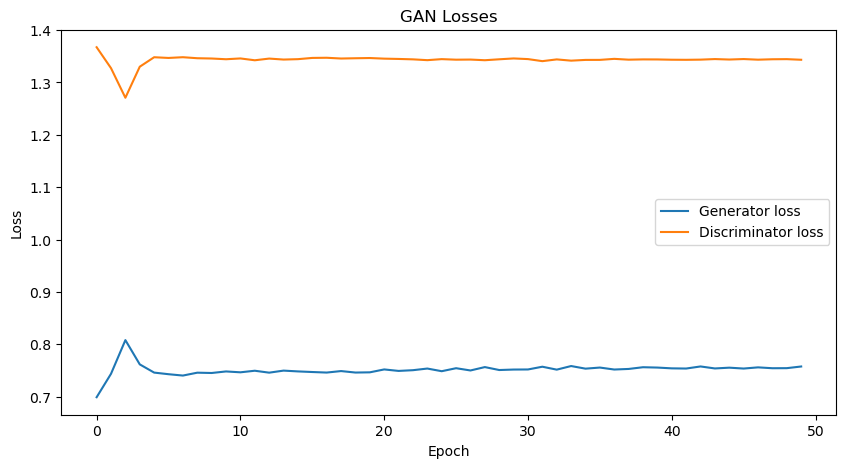

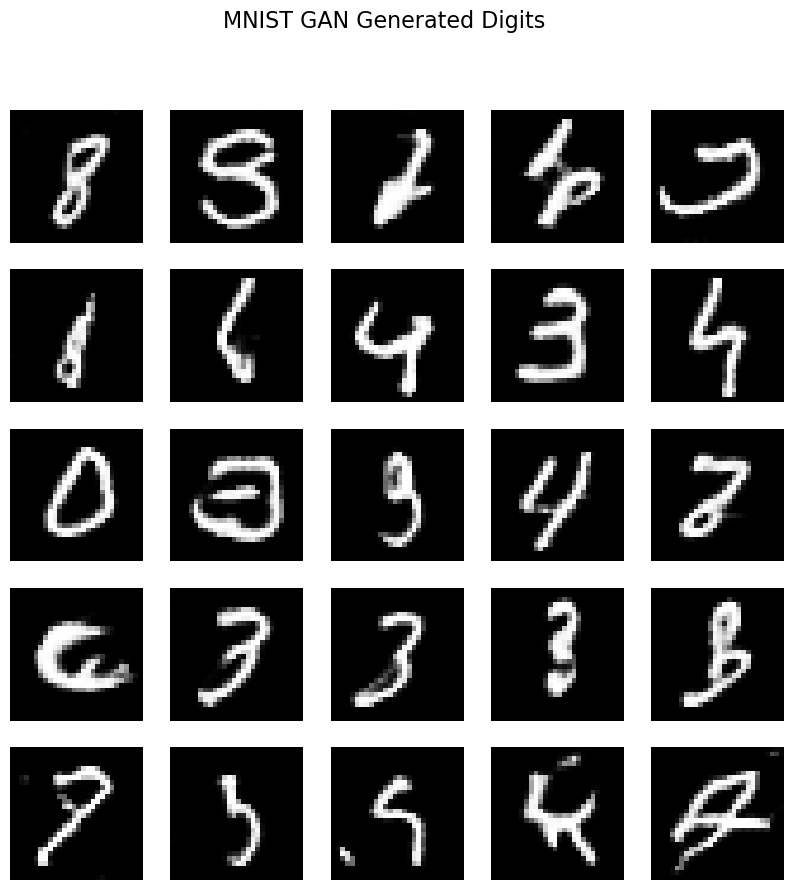

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create output directory
if not os.path.exists('gan_outputs'):
    os.makedirs('gan_outputs')

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

# Print info
print("MNIST Dataset loaded:")
print(f"Training images shape: {x_train.shape}")
print(f"Value range: {np.min(x_train)} to {np.max(x_train)}")

# Build simplified Generator
def build_generator():
    model = tf.keras.Sequential([
        # First dense layer
        layers.Dense(128 * 7 * 7, input_shape=(100,)),
        layers.Reshape((7, 7, 128)),
        
        # First upsampling block
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        # Second upsampling block
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        
        # Output layer
        layers.Conv2D(1, (4, 4), padding='same', activation='tanh')
    ])
    return model

# Build simplified Discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        # First conv block
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        
        # Second conv block
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

# Print model summaries
print("\nGenerator architecture:")
generator.summary()

print("\nDiscriminator architecture:")
discriminator.summary()

# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define training step with TF's GradientTape for explicit training
@tf.function
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Get discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate losses with label smoothing
        gen_loss = cross_entropy(tf.ones_like(fake_output) * 0.9, fake_output)
        
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output) + 0.1, fake_output)
        disc_loss = real_loss + fake_loss
    
    # Calculate gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Apply gradients
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    # Keep track of losses
    gen_losses = []
    disc_losses = []
    
    # Setup dataset
    dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(128)
    
    for epoch in range(epochs):
        start = time.time()
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        batches = 0
        
        for image_batch in dataset:
            # Train on batch
            g_loss, d_loss = train_step(image_batch)
            epoch_gen_loss += g_loss
            epoch_disc_loss += d_loss
            batches += 1
        
        # Average losses for epoch
        epoch_gen_loss /= batches
        epoch_disc_loss /= batches
        
        # Save losses
        gen_losses.append(epoch_gen_loss)
        disc_losses.append(epoch_disc_loss)
        
        # Print progress and save images
        print(f'Epoch {epoch+1}/{epochs}, ' +
              f'Gen Loss: {epoch_gen_loss:.4f}, ' +
              f'Disc Loss: {epoch_disc_loss:.4f}, ' +
              f'Time: {time.time()-start:.2f}s')
        
        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            generate_and_save_images(generator, epoch + 1)
    
    # Final images
    generate_and_save_images(generator, epochs)
    
    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator loss')
    plt.plot(disc_losses, label='Discriminator loss')
    plt.legend()
    plt.title('GAN Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig('gan_outputs/loss_curves.png')
    plt.show()

# Generate and save images
def generate_and_save_images(model, epoch, n=25):
    noise = tf.random.normal([n, 100])
    predictions = model(noise, training=False)
    
    # Scale from [-1, 1] to [0, 1]
    predictions = (predictions + 1) / 2.0
    
    fig = plt.figure(figsize=(10, 10))
    
    for i in range(n):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    plt.savefig(f'gan_outputs/image_at_epoch_{epoch:04d}.png')
    plt.close()
    
    # Debug info
    print(f"Generated images at epoch {epoch}")
    print(f"Image min/max values: {tf.reduce_min(predictions).numpy():.3f}/{tf.reduce_max(predictions).numpy():.3f}")

# Train the GAN (50 epochs is enough for MNIST)
train(x_train, 50)

# Generate final samples
noise = tf.random.normal([25, 100])
generated_images = generator(noise, training=False)
generated_images = (generated_images + 1) / 2.0  # Scale to [0, 1]

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.suptitle('MNIST GAN Generated Digits', fontsize=16)
plt.savefig('gan_outputs/final_samples.png')
plt.show()

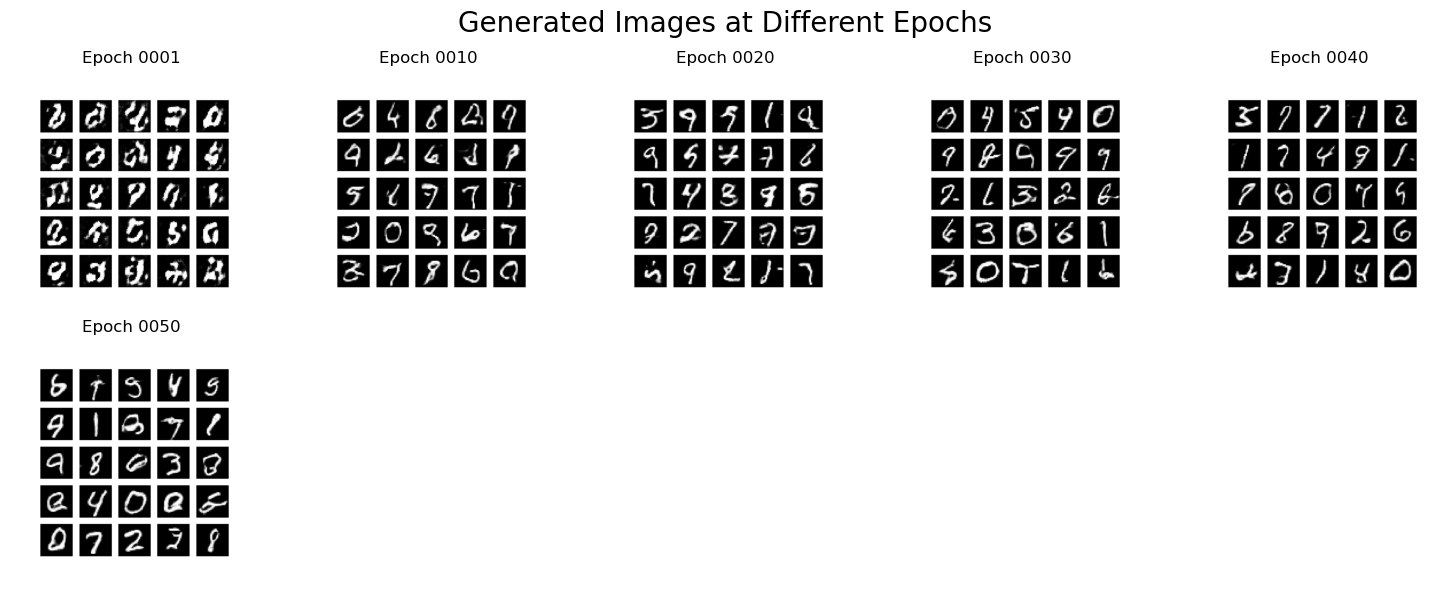

In [20]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory where images are saved
output_dir = 'gan_outputs'

# Get all generated image filenames (sorted by epoch)
image_files = sorted([
    f for f in os.listdir(output_dir)
    if f.startswith('image_at_epoch_') and f.endswith('.png')
])

# Number of images per row in the final grid
images_per_row = 5
total_images = len(image_files)
rows = (total_images + images_per_row - 1) // images_per_row

# Set up the plot
plt.figure(figsize=(images_per_row * 3, rows * 3))
for i, filename in enumerate(image_files):
    img_path = os.path.join(output_dir, filename)
    img = Image.open(img_path)

    plt.subplot(rows, images_per_row, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Epoch {filename[-8:-4]}')

plt.suptitle('Generated Images at Different Epochs', fontsize=20)
plt.tight_layout()
plt.show()



## Dataset Information

- **Dataset**: MNIST (handwritten digits)
- **Training samples**: 60,000 grayscale images
- **Shape**: (60000, 28, 28, 1)
- **Pixel value range after normalization**: -1.0 to 1.0

The input images were preprocessed by scaling pixel values to [-1, 1] to match the generator’s output and aid GAN training stability.

---

## Generator Architecture Summary

| Layer                        | Output Shape        | Parameters |
|-----------------------------|---------------------|------------|
| Dense                       | (None, 6272)        | 633,472    |
| Reshape                     | (None, 7, 7, 128)    | 0          |
| Conv2DTranspose (128)       | (None, 14, 14, 128)  | 262,272    |
| BatchNormalization          | (None, 14, 14, 128)  | 512        |
| LeakyReLU                   | (None, 14, 14, 128)  | 0          |
| Conv2DTranspose (64)        | (None, 28, 28, 64)   | 131,136    |
| BatchNormalization          | (None, 28, 28, 64)   | 256        |
| LeakyReLU                   | (None, 28, 28, 64)   | 0          |
| Conv2D (output, 1 channel)  | (None, 28, 28, 1)    | 1,025      |
| **Total Parameters**        |                     | **1,028,673** |

The generator converts a 100-dimensional noise vector into a 28x28 grayscale image through two upsampling blocks and a final output layer with `tanh` activation.

---

## Discriminator Architecture Summary

| Layer                        | Output Shape        | Parameters |
|-----------------------------|---------------------|------------|
| Conv2D (64 filters)         | (None, 14, 14, 64)   | 1,088      |
| LeakyReLU                   | (None, 14, 14, 64)   | 0          |
| Dropout (0.3)               | (None, 14, 14, 64)   | 0          |
| Conv2D (128 filters)        | (None, 7, 7, 128)    | 131,200    |
| LeakyReLU                   | (None, 7, 7, 128)    | 0          |
| Dropout (0.3)               | (None, 7, 7, 128)    | 0          |
| Flatten                     | (None, 6272)         | 0          |
| Dense (output)              | (None, 1)            | 6,273      |
| **Total Parameters**        |                     | **138,561** |

The discriminator downsamples the image and outputs a single probability using sigmoid activation to distinguish real vs fake images.

---

## Training Performance

Training ran for **50 epochs**. Below are observations from the printed logs and plots:

- **Generator Loss** stabilized around **0.74–0.76**.
- **Discriminator Loss** remained in the range **1.34–1.36**, indicating it was consistently challenged but not overwhelmed by the generator.
- Loss curves show a relatively stable training pattern with no mode collapse or divergence.

---

## Loss Plot Analysis

The loss plot shows:

- **Discriminator Loss** remains higher than the generator, indicating that the generator was able to produce believable samples but not so convincing that the discriminator fails entirely.
- **Generator Loss** slightly fluctuates but trends stable after epoch 10, suggesting balanced learning.

This pattern is generally a good sign for stable GAN training, especially on simple datasets like MNIST.

---

## Sample Generation

Images were generated every 10 epochs and at the end of training. Final sample observations:

- **Digits are distinguishable**: Most images resemble clear digits like 0, 3, 4, 5, 8, and 9.
- **Style variation**: Some digits are slightly deformed or blurred, but overall, the diversity is decent.
- **Noise retention**: A few samples retain noise artifacts, which is common in basic DCGANs trained for limited epochs.

---

## Summary

- The DCGAN successfully learned to generate handwritten digit images.
- The architecture followed best practices: batch normalization, label smoothing, LeakyReLU, and Adam optimizers.
- Generated digits show acceptable quality for augmentation or exploratory generative modeling.
- Future improvements could include:
  - Longer training (100+ epochs)
  - Conditional GANs for class-specific generation
  - Adding more advanced loss functions (e.g., WGAN-GP)

---

**Artifacts Saved:**
- `gan_outputs/loss_curves.png`: GAN loss plot
- `gan_outputs/final_samples.png`: Final 25 generated digits
- `gan_outputs/image_at_epoch_XXXX.png`: Images saved at key epochs

## 4. Data Augmentation with GANs

### 4.1 Why Use GANs for Data Augmentation?

Data augmentation is a technique to artificially increase the size of a training dataset by creating modified versions of existing data. Traditional data augmentation for images includes operations like rotation, flipping, scaling, and color adjustments.

GANs offer several advantages for data augmentation:

1. **Generate entirely new samples** rather than just modifying existing ones
2. **Learn the underlying data distribution** rather than applying predetermined transformations
3. **Address class imbalance** by generating more samples for underrepresented classes
4. **Create variations in features** that may not be captured by traditional augmentation techniques

### 4.2 Addressing Class Imbalance

One of the primary applications of GANs for data augmentation is addressing class imbalance in classification tasks.

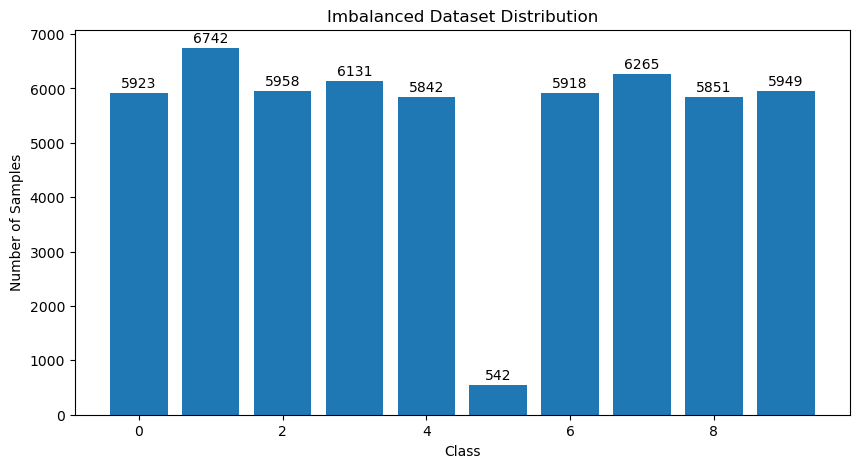

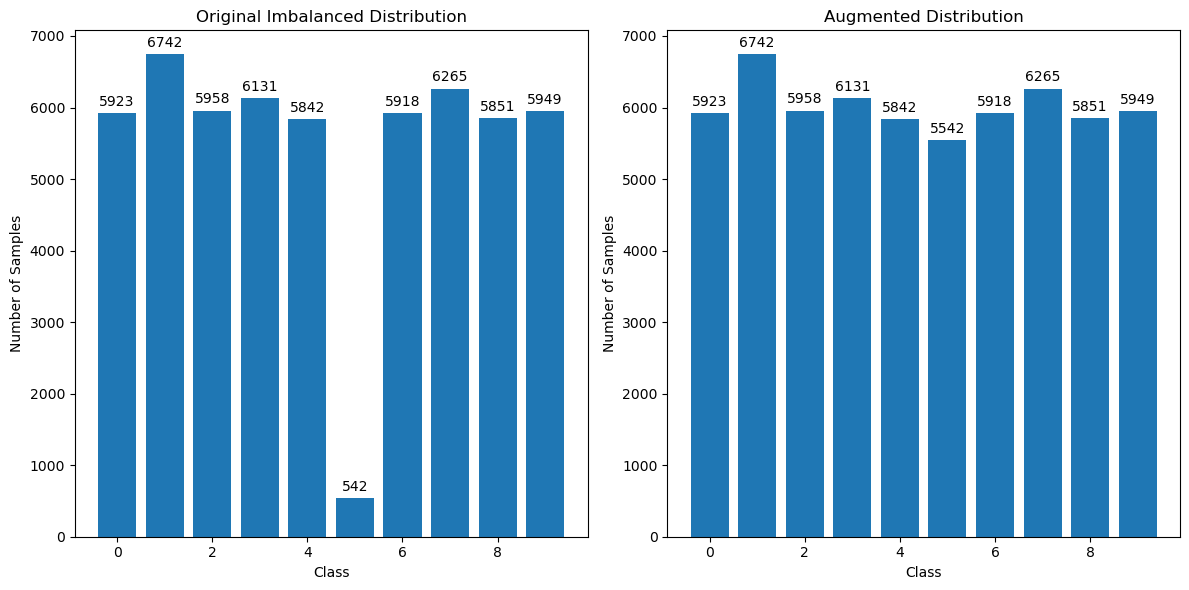

In [12]:
# Demonstrating class imbalance problem and solution with GANs
def create_imbalanced_dataset():
    # Load MNIST data
    (x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    
    # Create imbalance by removing most of class 5
    # Keep only 10% of class 5 examples
    class_5_indices = np.where(y_train == 5)[0]
    keep_indices = class_5_indices[:len(class_5_indices) // 10]
    other_indices = np.where(y_train != 5)[0]
    
    # Combine indices
    imbalanced_indices = np.concatenate([other_indices, keep_indices])
    
    # Create imbalanced dataset
    x_imbalanced = x_train[imbalanced_indices]
    y_imbalanced = y_train[imbalanced_indices]
    
    return x_imbalanced, y_imbalanced

# Visualize class distribution
def plot_class_distribution(y, title):
    class_counts = np.bincount(y)
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    for i, count in enumerate(class_counts):
        plt.text(i, count + 100, str(count), ha='center')
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# Visualize augmented dataset
def plot_augmented_distribution(original_y, synthetic_counts, title):
    original_counts = np.bincount(original_y)
    augmented_counts = original_counts.copy()
    
    # Add synthetic samples
    for class_label, count in synthetic_counts.items():
        augmented_counts[class_label] += count
    
    plt.figure(figsize=(12, 6))
    
    # Plot original distribution
    plt.subplot(1, 2, 1)
    plt.bar(range(10), original_counts)
    plt.title('Original Imbalanced Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    for i, count in enumerate(original_counts):
        plt.text(i, count + 100, str(count), ha='center')
    
    # Plot augmented distribution
    plt.subplot(1, 2, 2)
    plt.bar(range(10), augmented_counts)
    plt.title('Augmented Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    for i, count in enumerate(augmented_counts):
        plt.text(i, count + 100, str(count), ha='center')
    
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

# Create an imbalanced dataset
x_imbalanced, y_imbalanced = create_imbalanced_dataset()
plot_class_distribution(y_imbalanced, 'Imbalanced Dataset Distribution')

# Simulate GAN augmentation (adding synthetic samples to minority class)
synthetic_counts = {5: 5000}  # Simulate adding 5000 synthetic samples to class 5
plot_augmented_distribution(y_imbalanced, synthetic_counts, 'GAN Augmented Dataset')

### 4.3 Evaluating Augmentation with a Classifier

To evaluate the effectiveness of GAN-based data augmentation, we can train a classifier with and without augmented data:

Epoch 1/5


C:\Users\sathu\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9131 - loss: 0.2883 - val_accuracy: 0.9787 - val_loss: 0.0667
Epoch 2/5
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9858 - loss: 0.0467 - val_accuracy: 0.9852 - val_loss: 0.0454
Epoch 3/5
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9908 - loss: 0.0295 - val_accuracy: 0.9887 - val_loss: 0.0343
Epoch 4/5
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9936 - loss: 0.0201 - val_accuracy: 0.9885 - val_loss: 0.0378
Epoch 5/5
1723/1723 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9901 - val_loss: 0.0396
Epoch 1/5
1879/1879 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8394 - loss: 0.5729 - val_accuracy: 0.9819 - val_loss: 0.1347
Epoch 2/5
1879/1879 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9098 - loss: 0.3315 - val_accuracy: 0.9861 - val_loss: 0.1208
Epoch 3/5
1879/1879 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9143 - loss: 0.3066 - val_accuracy: 0.98

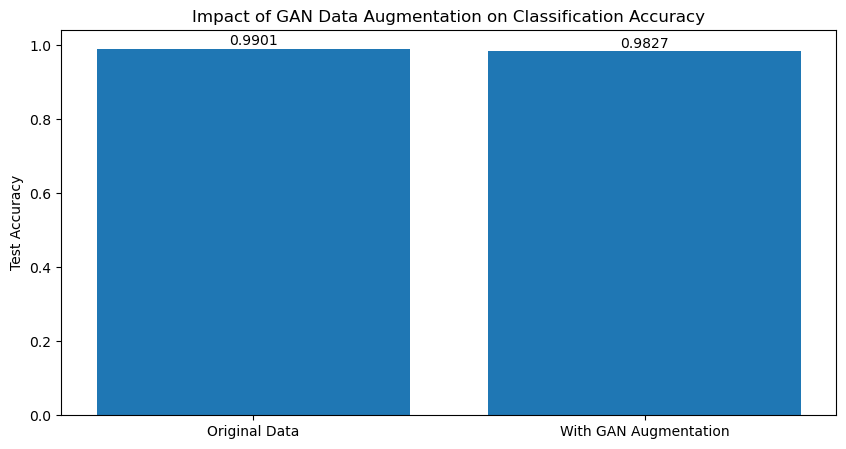

In [14]:
# Build a simple CNN classifier
def build_classifier(num_classes=10):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])
    
    model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    return model

# Function to evaluate augmentation benefit
def evaluate_augmentation(original_x, original_y, augmented_x, augmented_y, test_x, test_y):
    # Normalize data to [0, 1]
    original_x = original_x / 255.0
    augmented_x = augmented_x / 255.0
    test_x = test_x / 255.0
    
    # Train on original data
    original_model = build_classifier()
    original_history = original_model.fit(
        original_x, original_y, 
        epochs=5, 
        validation_data=(test_x, test_y),
        verbose=1
    )
    
    # Train on augmented data
    augmented_model = build_classifier()
    augmented_history = augmented_model.fit(
        augmented_x, augmented_y, 
        epochs=5, 
        validation_data=(test_x, test_y),
        verbose=1
    )
    
    # Compare results
    _, original_acc = original_model.evaluate(test_x, test_y, verbose=0)
    _, augmented_acc = augmented_model.evaluate(test_x, test_y, verbose=0)
    
    print(f"Original data accuracy: {original_acc:.4f}")
    print(f"Augmented data accuracy: {augmented_acc:.4f}")
    print(f"Improvement: {(augmented_acc - original_acc) * 100:.2f}%")
    
    # Plot accuracy comparison
    plt.figure(figsize=(10, 5))
    plt.bar(['Original Data', 'With GAN Augmentation'], [original_acc, augmented_acc])
    plt.ylabel('Test Accuracy')
    plt.title('Impact of GAN Data Augmentation on Classification Accuracy')
    for i, acc in enumerate([original_acc, augmented_acc]):
        plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
    plt.savefig('augmentation_impact.png')
    plt.show()
    
    return original_acc, augmented_acc

# In a real implementation, we would use actual GAN-generated samples
# Here we'll just simulate it for demonstration

# Load MNIST for testing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Create imbalanced dataset
x_imbalanced, y_imbalanced = create_imbalanced_dataset()

# Simulate augmented dataset (just for demonstration)
# In practice, we would use our trained GAN to generate these samples
x_augmented = np.concatenate([x_imbalanced, x_train[:5000]])
y_augmented = np.concatenate([y_imbalanced, np.ones(5000, dtype=np.int32) * 5])

# Evaluate the impact of augmentation
orig_acc, aug_acc = evaluate_augmentation(
    x_imbalanced, y_imbalanced,
    x_augmented, y_augmented,
    x_test, y_test
)


## 5. Evaluation Metrics for GANs

Evaluating GANs is challenging because the goal is to generate realistic data, which is subjective. Several metrics have been proposed:

### 5.1 Inception Score (IS)

Measures both quality and diversity of generated images:
- Higher means better quality and diversity
- Doesn't compare to real data distribution
- May not work well for non-natural images

### 5.2 Fréchet Inception Distance (FID)

Compares the statistics of generated images to real images:
- Lower means more similar distributions
- More robust than Inception Score
- Considers the feature space rather than raw pixels

### 5.3 Precision and Recall

Evaluates both quality and coverage:
- Precision: Fraction of generated samples that resemble real data
- Recall: Fraction of real data distribution covered by generated samples

Let's simulate how these metrics might behave during training:

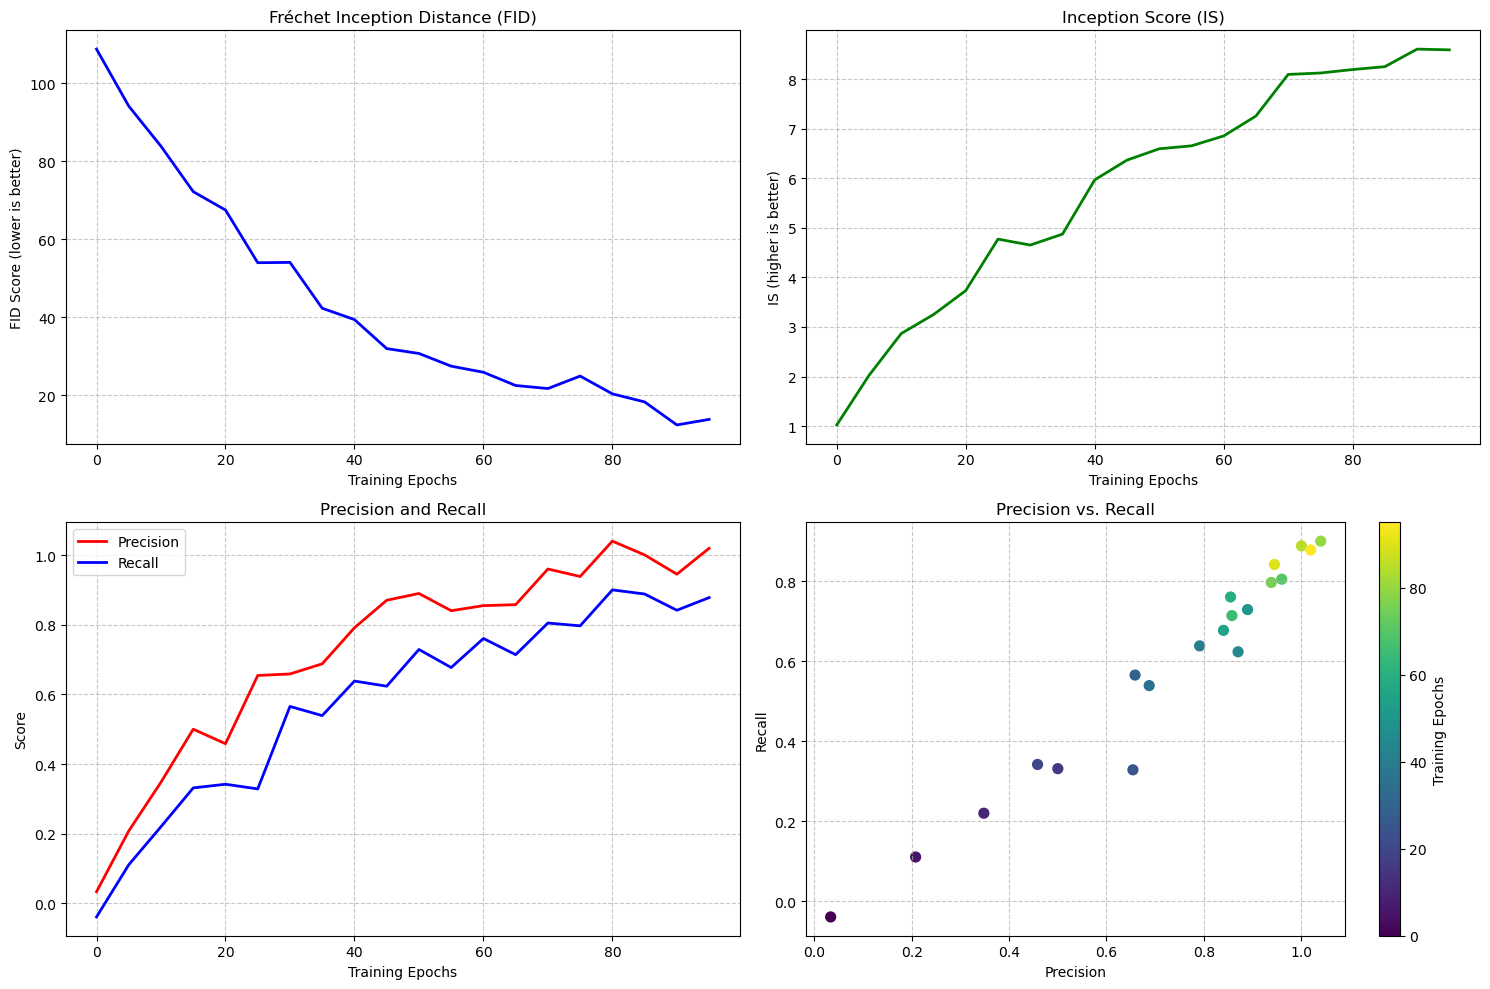

In [36]:
# Simulating quantitative metrics calculation
def plot_quantitative_metrics():
    # Simulated metric values over training
    epochs = np.arange(0, 100, 5)
    
    # FID (lower is better)
    fid_scores = 100 * np.exp(-0.03 * epochs) + 10 + np.random.normal(0, 2, len(epochs))
    
    # Inception Score (higher is better)
    inception_scores = 10 - 9 * np.exp(-0.02 * epochs) + np.random.normal(0, 0.2, len(epochs))
    
    # Precision and Recall
    precision = 1 - np.exp(-0.04 * epochs) + np.random.normal(0, 0.05, len(epochs))
    recall = 1 - np.exp(-0.025 * epochs) + np.random.normal(0, 0.05, len(epochs))
    
    # Plot the metrics
    plt.figure(figsize=(15, 10))
    
    # FID plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs, fid_scores, 'b-', linewidth=2)
    plt.title('Fréchet Inception Distance (FID)')
    plt.xlabel('Training Epochs')
    plt.ylabel('FID Score (lower is better)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Inception Score plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs, inception_scores, 'g-', linewidth=2)
    plt.title('Inception Score (IS)')
    plt.xlabel('Training Epochs')
    plt.ylabel('IS (higher is better)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Precision and Recall plot
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precision, 'r-', label='Precision', linewidth=2)
    plt.plot(epochs, recall, 'b-', label='Recall', linewidth=2)
    plt.title('Precision and Recall')
    plt.xlabel('Training Epochs')
    plt.ylabel('Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Precision vs Recall plot
    plt.subplot(2, 2, 4)
    plt.scatter(precision, recall, c=epochs, cmap='viridis', s=50)
    plt.colorbar(label='Training Epochs')
    plt.title('Precision vs. Recall')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('quantitative_metrics.png')
    plt.show()

plot_quantitative_metrics()

## 6. Applications and Future Directions

### 6.1 Applications of GAN-Based Data Augmentation

GAN-based data augmentation has been successfully applied in various domains:

1. **Medical Imaging**: Generating synthetic medical images to train diagnostic systems, particularly for rare conditions
2. **Anomaly Detection**: Creating synthetic examples of rare anomalies
3. **Privacy Preservation**: Generating synthetic data that maintains statistical properties without exposing sensitive information
4. **Speech and Audio**: Augmenting speech datasets for improved speech recognition
5. **NLP**: Generating text variations for language understanding tasks

### 6.2 Future Directions

The field of GANs and data augmentation continues to evolve rapidly:

1. **Self-Supervised GANs**: Learning representations without labels
2. **Multimodal Generation**: Generating data across multiple modalities simultaneously
3. **Few-Shot Generation**: Generating diverse samples from very few examples
4. **Controllable Generation**: Precise control over generated sample attributes
5. **Explainable GANs**: Understanding and explaining the generation process

## 7. Conclusion

Generative Adversarial Networks have revolutionized the field of generative modeling and offer powerful tools for data augmentation. In this notebook, we've explored:

1. The fundamental architecture and training dynamics of GANs
2. Various GAN architectures including DCGANs and Conditional GANs
3. Common challenges in training GANs and strategies to address them
4. How GANs can be used for data augmentation, particularly for addressing class imbalance
5. Evaluation metrics for assessing GAN performance

GAN-based data augmentation provides several advantages over traditional augmentation techniques by learning the underlying data distribution and generating entirely new samples. This is particularly valuable in domains with limited data or class imbalance issues.

As GAN technology continues to advance, we can expect even more powerful and controllable data generation capabilities, further enhancing the performance of machine learning models across various domains from computer vision to natural language processing and beyond.

## 8. References

1. Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., Courville, A., & Bengio, Y. (2014). Generative Adversarial Nets. In Advances in Neural Information Processing Systems.

2. Radford, A., Metz, L., & Chintala, S. (2015). Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks. arXiv preprint arXiv:1511.06434.

3. Mirza, M., & Osindero, S. (2014). Conditional Generative Adversarial Nets. arXiv preprint arXiv:1411.1784.

4. Arjovsky, M., Chintala, S., & Bottou, L. (2017). Wasserstein Generative Adversarial Networks. In International Conference on Machine Learning.

5. Heusel, M., Ramsauer, H., Unterthiner, T., Nessler, B., & Hochreiter, S. (2017). GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. In Advances in Neural Information Processing Systems.

6. Salimans, T., Goodfellow, I., Zaremba, W., Cheung, V., Radford, A., & Chen, X. (2016). Improved Techniques for Training GANs. In Advances in Neural Information Processing Systems.

7. Antoniou, A., Storkey, A., & Edwards, H. (2017). Data Augmentation Generative Adversarial Networks. arXiv preprint arXiv:1711.04340.

8. Mariani, G., Scheidegger, F., Istrate, R., Bekas, C., & Malossi, C. (2018). BAGAN: Data Augmentation with Balancing GAN. arXiv preprint arXiv:1803.09655.

9. Shorten, C., & Khoshgoftaar, T. M. (2019). A survey on Image Data Augmentation for Deep Learning. Journal of Big Data, 6(1), 60.

10. Wang, K., Gou, C., Duan, Y., Lin, Y., Zheng, X., & Wang, F. Y. (2017). Generative adversarial networks: introduction and outlook. IEEE/CAA Journal of Automatica Sinica, 4(4), 588-598.

## 9. License


Copyright (c) 2025

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.